The code to create random shapes at the beginning comes form https://github.com/jrieke/shape-detection

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import tensorflow as tf

In [3]:
import cairo

num_imgs = 50000

img_size = 32
min_object_size = 4
max_object_size = 16
num_objects = 1

bboxes = np.zeros((num_imgs, num_objects, 4)) 
imgs = np.zeros((num_imgs, img_size, img_size, 4), dtype=np.uint8) 
shapes = np.zeros((num_imgs, num_objects), dtype=int)

num_shapes = 3
shape_labels = ['rectangle', 'circle', 'triangle']
colors = np.zeros((num_imgs, num_objects), dtype=int)
num_colors = 3
color_labels = ['b', 'g', 'r']

In [4]:
for i_img in range(num_imgs): 
    
    surface = cairo.ImageSurface.create_for_data(imgs[i_img], cairo.FORMAT_ARGB32, img_size, img_size)
    cr = cairo.Context(surface) 

    cr.set_source_rgb(1, 1, 1)
    cr.paint()
    
    for i_object in range(num_objects):          
        shape = np.random.randint(num_shapes)    
        shapes[i_img, i_object] = shape         
        
        if shape == 0:  # rectangle
            w, h = np.random.randint(min_object_size, max_object_size, size=2)  
            x = np.random.randint(0, img_size - w)                               
            y = np.random.randint(0, img_size - h)
            bboxes[i_img, i_object] = [x, y, w, h]                               
            cr.rectangle(x, y, w, h)                                            
            
        elif shape == 1:  # circle   
            r = 0.5 * np.random.randint(min_object_size, max_object_size)
            x = np.random.randint(r, img_size - r)
            y = np.random.randint(r, img_size - r)
            bboxes[i_img, i_object] = [x - r, y - r, 2 * r, 2 * r]
            cr.arc(x, y, r, 0, 2*np.pi)     
            
        elif shape == 2:  # triangle
            w, h = np.random.randint(min_object_size, max_object_size, size=2)
            x = np.random.randint(0, img_size - w)
            y = np.random.randint(0, img_size - h)
            bboxes[i_img, i_object] = [x, y, w, h]
            cr.move_to(x, y)
            cr.line_to(x+w, y)
            cr.line_to(x+w, y+h)
            cr.line_to(x, y)
            cr.close_path()
            
        cr.set_source_rgb(0, 0, 0)
        cr.fill()

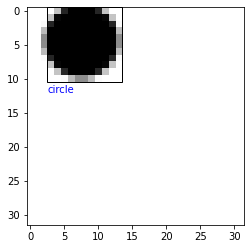

In [5]:
i = np.random.randint(num_imgs)

plt.imshow(imgs[i])

for bbox, shape, color in zip(bboxes[i], shapes[i], colors[i]):
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='k', fc='none'))
    plt.annotate(shape_labels[shape], (bbox[0], bbox[1] + bbox[3] + 1.5), color=color_labels[color], clip_on=False)


In [6]:
X = (imgs - 128.) / 255.
X = X[:,:,:,0]
X.shape, np.mean(X), np.std(X)

((50000, 32, 32), 0.4281356501991429, 0.2504054976339165)

In [7]:
labels = shapes.reshape(-1)
labels

array([2, 1, 1, ..., 2, 0, 1])

In [8]:
from tensorflow.keras.utils import to_categorical

labels = to_categorical(labels)
labels[:10, :]

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [9]:
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = labels[:i]
test_y = labels[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

## MLP 

In [10]:
mlp_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32)),
    tf.keras.layers.Dense(128, activation='relu'),  
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3)                
])

In [11]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01)   
xentropy_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [12]:
mlp_model.compile(optimizer=opt, loss=xentropy_loss, metrics=['accuracy'])

In [13]:
mlp_model.fit(train_X, train_y, batch_size = 64, epochs=10)

Epoch 1/10
625/625 [==============================] - 1s 857us/step - loss: 1.0006 - accuracy: 0.4737
Epoch 2/10
625/625 [==============================] - 1s 921us/step - loss: 0.9369 - accuracy: 0.5268
Epoch 3/10
625/625 [==============================] - 1s 913us/step - loss: 0.8965 - accuracy: 0.5628
Epoch 4/10
625/625 [==============================] - 1s 980us/step - loss: 0.8566 - accuracy: 0.5973
Epoch 5/10
625/625 [==============================] - 1s 922us/step - loss: 0.8110 - accuracy: 0.6327
Epoch 6/10
625/625 [==============================] - 1s 882us/step - loss: 0.7559 - accuracy: 0.6722
Epoch 7/10
625/625 [==============================] - 1s 889us/step - loss: 0.7078 - accuracy: 0.6951
Epoch 8/10
625/625 [==============================] - 1s 892us/step - loss: 0.6508 - accuracy: 0.7245
Epoch 9/10
625/625 [==============================] - 1s 898us/step - loss: 0.5973 - accuracy: 0.7491
Epoch 10/10
625/625 [==============================] - 1s 906us/step - loss: 0.555

In [14]:
mlp_model.evaluate(test_X,  test_y, verbose=2);

313/313 - 0s - loss: 0.5436 - accuracy: 0.7755


In [15]:
pred_y = mlp_model.predict(test_X)

In [28]:
def decode_label(vector):
    index = np.argmax(vector)
    return shape_labels[index]

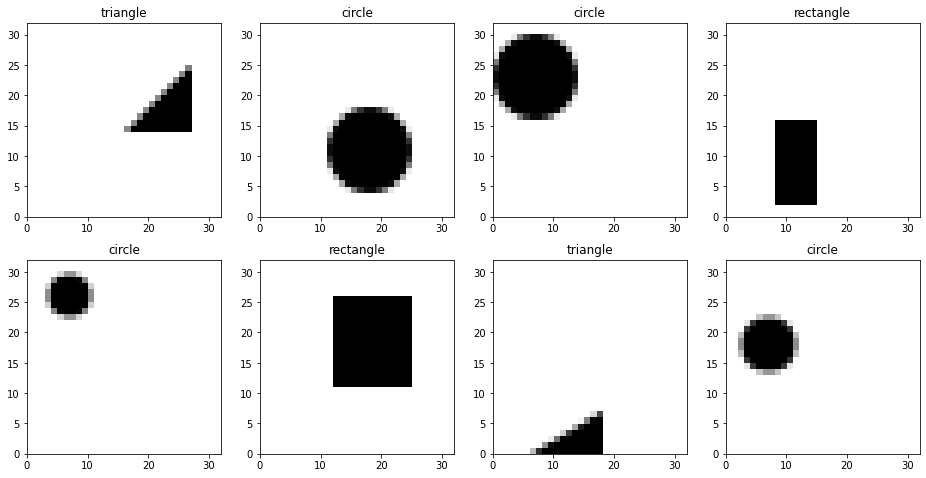

In [32]:
plt.figure(figsize=(16, 8))
for i_subplot in range(1, 9):
    plt.subplot(2, 4, i_subplot)
    i = np.random.randint(len(test_X))
    plt.imshow(test_imgs[i], interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    plt.title(decode_label(pred_y[i]))

## CNN

In [18]:
X = (imgs - 128.) / 255.
X = X.transpose(0,3,1,2)
X.shape

(50000, 4, 32, 32)

In [19]:
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = labels[:i]
test_y = labels[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

In [20]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=4, kernel_size=(3,3), strides=(2,2), padding = 'same', activation = 'relu'), 
    tf.keras.layers.BatchNormalization(),   
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), strides=(2,2), padding = 'same', activation = 'relu'),  
    tf.keras.layers.BatchNormalization(),  
    tf.keras.layers.Flatten(input_shape=(8,8,8)),
    tf.keras.layers.Dense(3)
    
])

In [21]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1)
xentropy_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [22]:
cnn_model.compile(optimizer=opt, loss=xentropy_loss, metrics=['accuracy'])

In [23]:
cnn_model.fit(train_X, train_y, batch_size=128, epochs=5)

Epoch 1/5
313/313 [==============================] - 2s 7ms/step - loss: 0.8641 - accuracy: 0.5796
Epoch 2/5
313/313 [==============================] - 2s 7ms/step - loss: 0.4410 - accuracy: 0.8183
Epoch 3/5
313/313 [==============================] - 2s 7ms/step - loss: 0.1672 - accuracy: 0.9473
Epoch 4/5
313/313 [==============================] - 2s 7ms/step - loss: 0.0844 - accuracy: 0.9763
Epoch 5/5
313/313 [==============================] - 2s 7ms/step - loss: 0.0576 - accuracy: 0.9844


In [24]:
cnn_model.evaluate(test_X,  test_y, verbose=2)

313/313 - 0s - loss: 0.0630 - accuracy: 0.9855


[0.06298983097076416, 0.9854999780654907]

### Plots

In [25]:
pred_y = cnn_model.predict(test_X)
pred_y[0]

array([ 1.1883708, -3.2599702,  5.932157 ], dtype=float32)

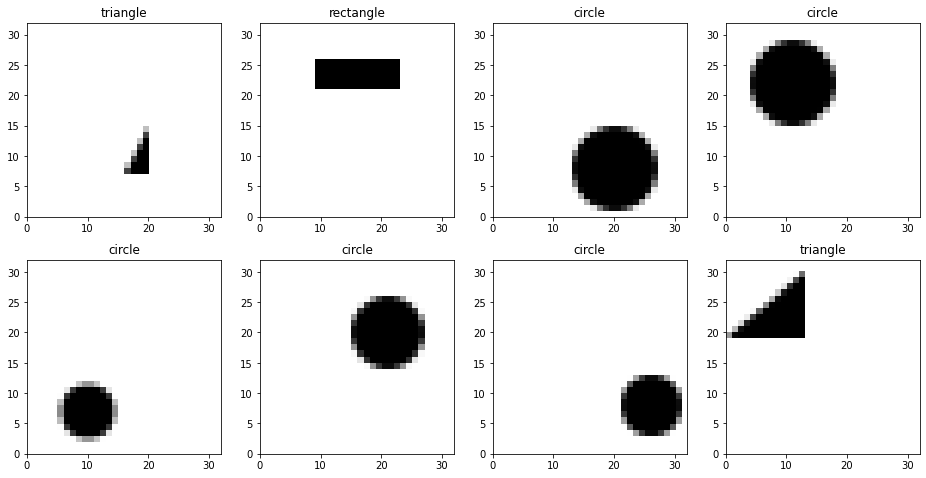

In [26]:
plt.figure(figsize=(16, 8))
for i_subplot in range(1, 9):
    plt.subplot(2, 4, i_subplot)
    i = np.random.randint(len(test_X))
    plt.imshow(test_imgs[i], interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    plt.title(decode_label(pred_y[i]))

----------------------------------------------------------------------